In [2]:
import numpy as np
from matplotlib import figure, gridspec,colors

import scanner_interpretation as scani

import healpy as hp

from matplotlib import colors,cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import visualization as vis

import dill



# bands = ["u_5_15", "u_15_25", "u_25_35", "u_35_45", "u_45_55", "u_55_65", "u_65_75", "u_75_90", "l_15_5", "l_25_15", "l_35_25", "l_45_35", "l_55_45", "l_65_55", "l_75_65", "l_90_75", "center"]
# versions = ["hess1","hess1u"]
# paths = [f"/lustre/fs22/group/hess/user/wybouwt/full_scanner_survey/{version}/{band}" for band in bands for version in versions]
# # mplets = scani.Multiplets(paths[0])
# # mplets.appendMultiplets(*[scani.Multiplets(path) for path in paths[1:]])
# mplet_list = [scani.Multiplets(path) for path in paths]


# unicorns = [9,18]
# for j in unicorns:
#     mplet_list[j].objectifyColumns()

    
# mplets = mplet_list[0]
# mplets.appendMultiplets(*mplet_list[1:])
with open("pickles/mplets.pkl","rb") as f:
    mplets = dill.load(f)

nosource_mask = mplets.table["TEVCAT_DISTANCES_DEG"] >= 0.2
Nmin4_mask = mplets.table["Nmax"] >= 4
Nmin5_mask = mplets.table["Nmax"] >= 5
dt1sec_mask = mplets.table["dt"] <= 1e9
xgal_mask = np.abs(mplets.table["MEDIAN_GLAT"]) > 5

Cornerplot of the resulting multiplets

In [ ]:
# plotting mplet results
from corner import corner

fig = corner(mplets.table.to_pandas(),var_names=["Nmax","dt","da"])
# fig.savefig("figures/combined/corner_center.png",facecolor="white",dpi=300)

TeVCat distance histogram

In [ ]:
current_mask = nosource_mask

vline_sourcebound = .2
hist = vis.hist(mplets.table[current_mask]["TEVCAT_DISTANCES_DEG"],bins="freedman",histtype="step",stacked=True)
ax = plt.gca()
ax.set_xlabel("Distance to nearest TeVCat source [deg]")
ax.set_ylabel("Counts")
ylim = ax.get_ylim()
ax.vlines(vline_sourcebound,0,ylim[1],color="red",ls="--",label=f"{vline_sourcebound} deg")
ax.set_ylim(*ylim)
# ax.set_yscale("log")
ax.set_xlim(0,15)
ax.legend()
# ax.set_xscale("log")
# plt.savefig("figures/combined/sourcedist_hist.png",facecolor="white")

HEALPix

In [ ]:
fig = plt.figure(dpi=300)

Nmax_mask = mplets.table["Nmax"] >= 4
dt_mask = mplets.table["dt"] <= 1e9
current_mask = nosource_mask*Nmax_mask*dt_mask

cmap = cm.jet
cmap.set_bad("r")
NSIDE = 2**5
m = scani.cat2hpx(mplets.table[current_mask]["MEDIAN_RA"],mplets.table[current_mask]["MEDIAN_DEC"],nside=NSIDE)
print(np.sqrt(hp.nside2pixarea(NSIDE,degrees=True)))
mmin, mmax = min(m),max(m)

hp.mollview(m,cmap=cmap, hold=True,nest=False,min=mmin,max=mmax,notext=True,fig=1,cbar=False,title="Transient tool applied on all H.E.S.S. data.")
#create a colorbar axis
cax = fig.add_axes([0.125, 0.1, 0.775, 0.03])

#create a colorbar and normalise it
# cmap.set_under("white")
# axs = fig.get_axes()
# axs[0].images[0].set_norm(colors.SymLogNorm(100))
cb = mpl.colorbar.ColorbarBase(cax,cmap=cmap,norm=mpl.colors.Normalize(vmin=mmin,vmax=mmax),
                               orientation='horizontal')
cb.set_label("Counts")
cb.solids.set_edgecolor("face")

plt.show()
# plt.savefig("figures/combined/healpy.png",facecolor="white")

Nmax histogram

In [ ]:
current_mask = nosource_mask

remaining_Nmax = max(mplets.table[current_mask]["Nmax"])
print(f"Nmax left after mask: {remaining_Nmax}")
hist = vis.hist(mplets.table[current_mask]["Nmax"],bins=range(3,remaining_Nmax+3),histtype="step")
ax = plt.gca()
ax.set_xlabel("Nmax")
ax.set_ylabel("Counts")
ax.set_yscale("log")
# ax.set_xticks(range(3,22))
# plt.savefig("figures/combined/Nmax_hist.png",facecolor="white")

In [ ]:
# current_mask = nosource_mask# * mplets.table["Nmax"] > 3
temp = mplets.table[current_mask]["Nmax","OBS_ID","dt","da","MEDIAN_GLAT","TEVCAT_SOURCE_NAME","TEVCAT_SOURCE_TYPE","TEVCAT_DISTANCES_DEG"]
temp[:]

In [ ]:
temp.sort["Nmax"]

In [ ]:
Nmax = 3
run_count_rate = 1/60
expected_photons_3sec = 3*run_count_rate

expected_photons_3sec

In [ ]:
from math import factorial
sum = 1

for i in range(Nmax):
    sum -= expected_photons_3sec**(i)*np.exp(-expected_photons_3sec)/(factorial(i))
sum
                                                                      
                                                                    

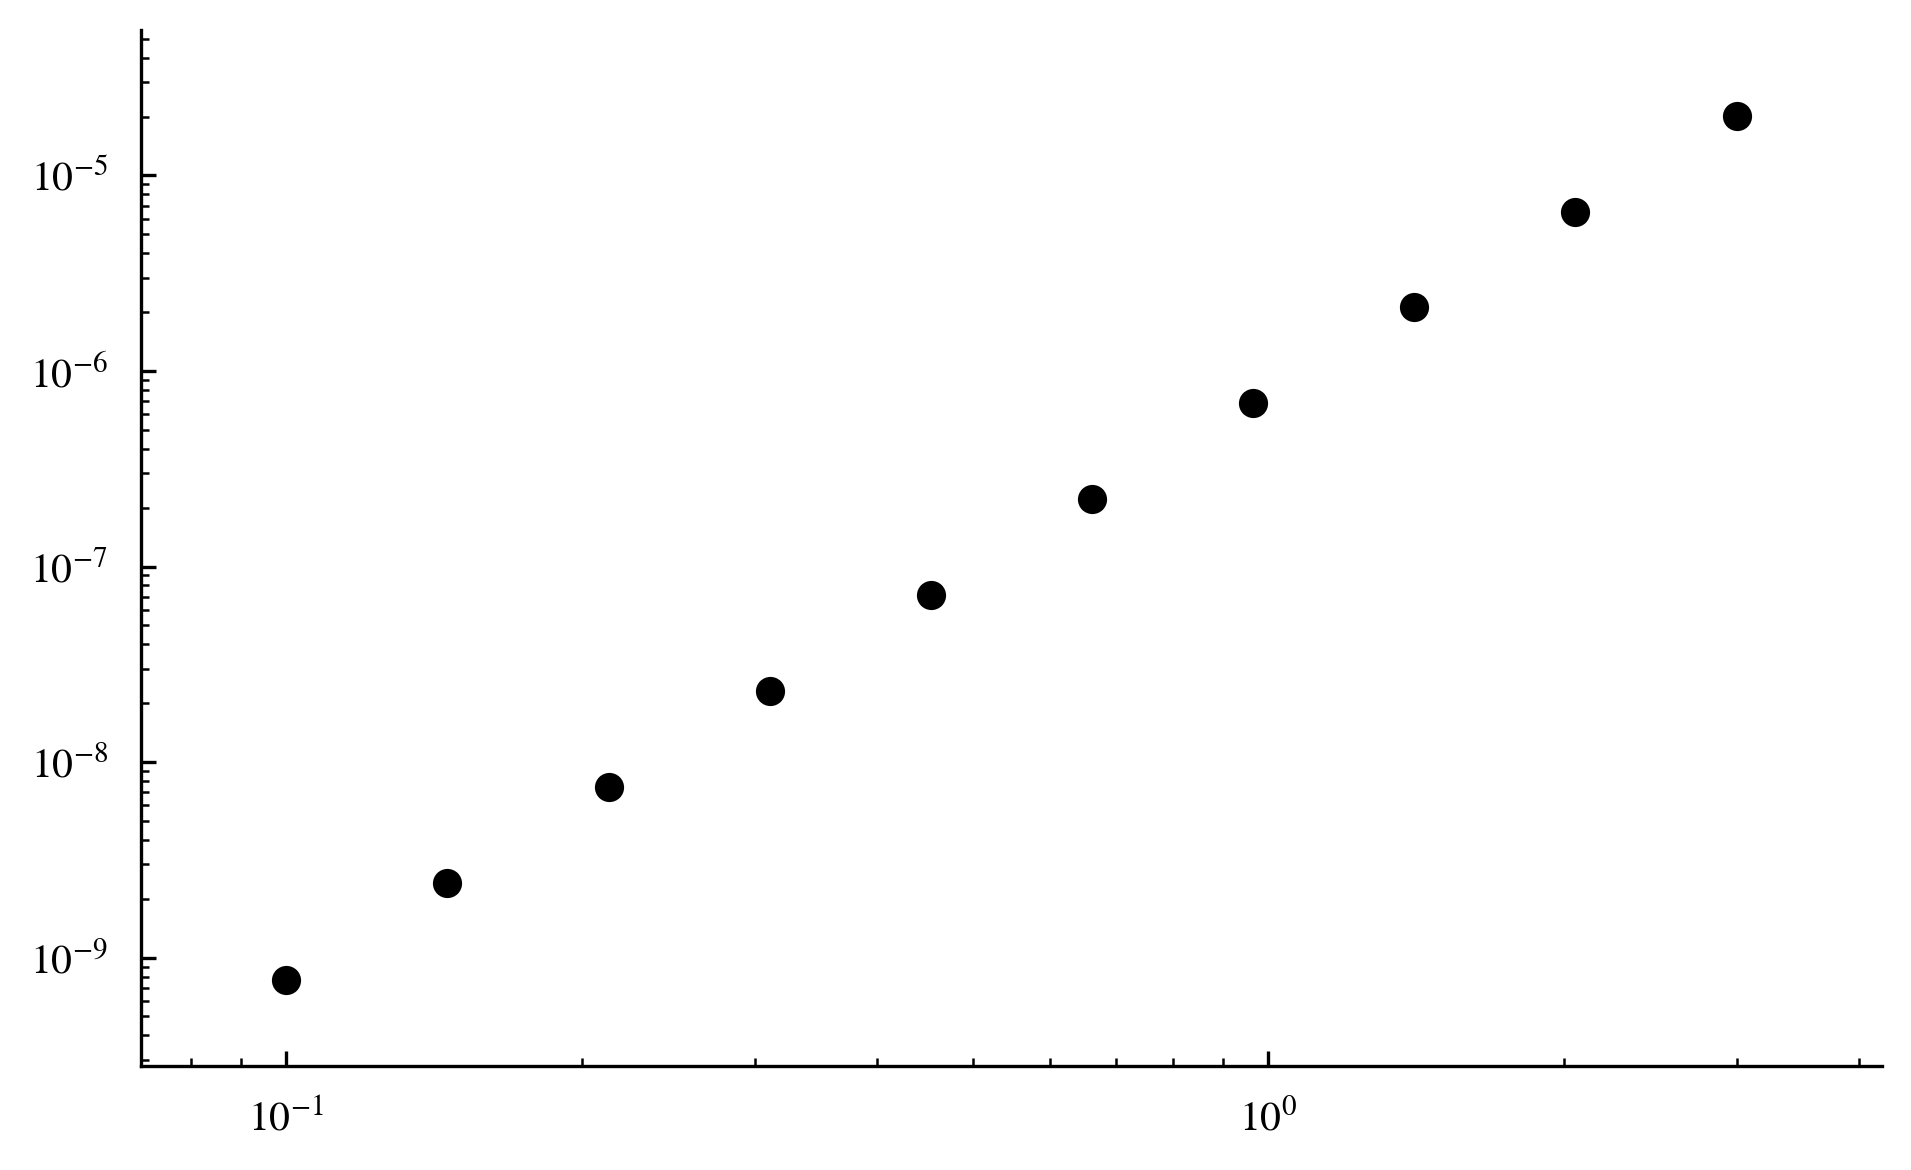

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial

@np.vectorize
def pvalue(lamb):
    Nmax = 3
    sum = 1
    for i in range(Nmax):
        sum -= lamb**(i)*np.exp(-lamb)/(factorial(i))
    return sum

dt = np.geomspace(0.1,3,10)
lamb = (1/60)*dt
pval = pvalue(lamb)
plt.scatter(dt,pval)
plt.xscale("log")
plt.yscale("log")
    
